In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd



In [2]:
# Step 1: Load your dataset
data_count = pd.read_csv('C:/Users/a0095989/Desktop/important/Thesis/Model_Thesis/imputed_deu_data.csv', parse_dates=[0])

# Step 2: Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_count[['AverageTemperature', 'Year', 'Month', 'TemperatureAnomaly', 'YearlyAvgTemperature']])



In [3]:
# Step 3: Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12  # Sequence length (e.g., 12 months)
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Step 4: Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



In [4]:
# Step 5: Build the Transformer-LSTM Model
def build_transformer_lstm(seq_length, n_features, n_heads, d_model, dropout_rate=0.1):
    # Input Layer
    inputs = Input(shape=(seq_length, n_features))

    # Transformer Encoder Block
    attention = MultiHeadAttention(num_heads=n_heads, key_dim=d_model)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = Add()([inputs, attention])  # Skip connection
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Feed Forward Network
    ffn = Dense(d_model, activation='relu')(attention)
    ffn = Dropout(dropout_rate)(ffn)
    ffn = Dense(n_features)(ffn)
    ffn = Add()([attention, ffn])  # Skip connection
    ffn = LayerNormalization(epsilon=1e-6)(ffn)

    # LSTM Layer
    lstm = LSTM(50, activation='relu', return_sequences=False)(ffn)
    lstm = Dropout(dropout_rate)(lstm)

    # Dense Output Layer
    outputs = Dense(1)(lstm)

    # Model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model Parameters
n_heads = 4
d_model = 32
dropout_rate = 0.1

model = build_transformer_lstm(SEQ_LENGTH, X_train.shape[2], n_heads, d_model, dropout_rate)

# Step 6: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Step 7: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)



Epoch 1/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 2/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 3/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 58s 11ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 5/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 68s 13ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 12/20

In [6]:
# Step 8: Evaluate the Model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Step 9: Make Predictions
y_pred = model.predict(X_test)



1640/1640 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0013
Test Loss: 0.0013312078081071377
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


Inverse Transformation Complete.


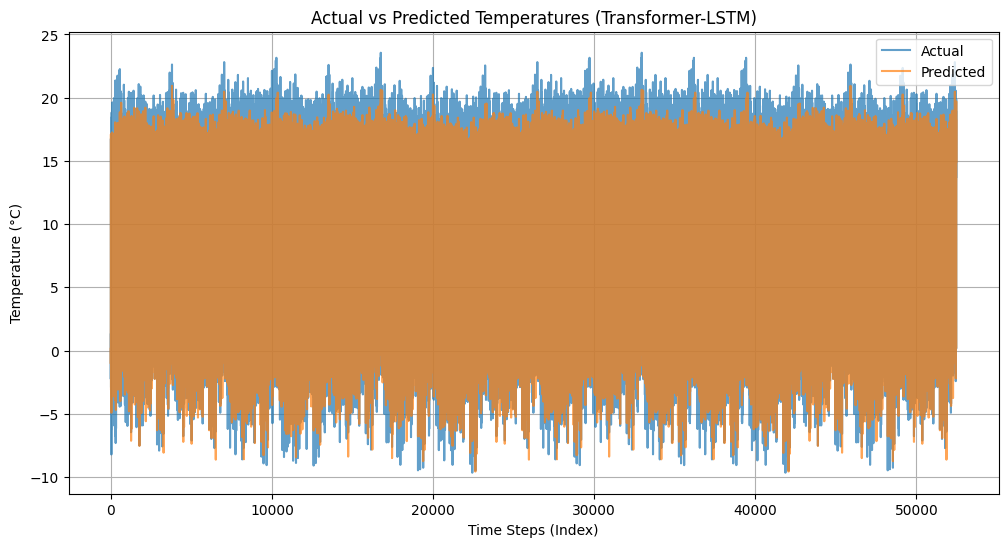

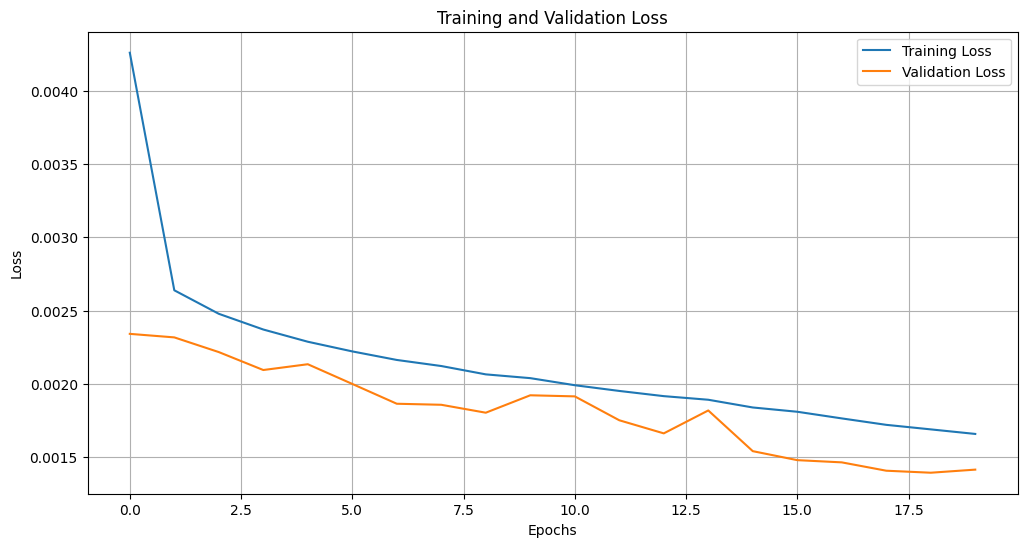

In [8]:
# Step 10: Inverse Transform Predictions and Actual Values

# Expand y_test and y_pred to match the scaler's expected input shape
y_test_expanded = np.zeros((len(y_test), data_scaled.shape[1]))
y_pred_expanded = np.zeros((len(y_pred), data_scaled.shape[1]))

# Place y_test and y_pred in the first column
y_test_expanded[:, 0] = y_test
y_pred_expanded[:, 0] = y_pred.flatten()

# Inverse transform using the scaler
y_test_unscaled = scaler.inverse_transform(y_test_expanded)[:, 0]
y_pred_unscaled = scaler.inverse_transform(y_pred_expanded)[:, 0]

print("Inverse Transformation Complete.")

# Step 11: Plot Actual vs Predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred_unscaled, label='Predicted', alpha=0.7)
plt.xlabel('Time Steps (Index)')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperatures (Transformer-LSTM)')
plt.legend()
plt.grid(True)
plt.show()

# Step 12: Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Ensure y_test_unscaled and y_pred_unscaled are correctly computed
# Expand y_test and y_pred for inverse transformation
y_test_expanded = np.zeros((len(y_test), data_scaled.shape[1]))
y_pred_expanded = np.zeros((len(y_pred), data_scaled.shape[1]))
y_test_expanded[:, 0] = y_test
y_pred_expanded[:, 0] = y_pred.flatten()
y_test_unscaled = scaler.inverse_transform(y_test_expanded)[:, 0]
y_pred_unscaled = scaler.inverse_transform(y_pred_expanded)[:, 0]

# Step 2: Calculate evaluation metrics

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R² Score
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
print(f"R² Score: {r2}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Root Mean Squared Percentage Error (RMSPE)
non_zero_mask = y_test_unscaled > 1e-5  # Avoid division by zero
rmspe = np.sqrt(np.mean(np.square((y_test_unscaled[non_zero_mask] - y_pred_unscaled[non_zero_mask]) / y_test_unscaled[non_zero_mask]))) * 100
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe}%")


Mean Absolute Error (MAE): 1.0196693320515016
Root Mean Squared Error (RMSE): 1.3062983772372596
R² Score: 0.9627347805726629
Mean Absolute Percentage Error (MAPE): 68.63991218768332%
Root Mean Squared Percentage Error (RMSPE): 491.83707581355947%


: 